<a href="https://colab.research.google.com/github/sujitojha1/ERA1/blob/main/Session10/ERA1_S10_CIFAR10_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Models & Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [44]:
!git clone https://github.com/abhilashreddyy/LearnDeepLearning/ -q --quiet
!mv LearnDeepLearning/lib/* ./
!rm -rf LearnDeepLearning

mv: cannot move 'LearnDeepLearning/lib/models' to './models': Directory not empty


In [42]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/abhilashreddyy/LearnDeepLearning/ -q --quiet
!mv LearnDeepLearning/lib/* ./
!rm -rf LearnDeepLearning
print("Loaded Modules and Models")

!pip install grad-cam -q --quiet

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet

# For inline matplotlib plotting
%matplotlib inline

mv: cannot move 'LearnDeepLearning/lib/models' to './models': Directory not empty
Loaded Modules and Models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Loading train and test data with transforms and loader functions

In [11]:
from data_loader import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, json-or-python[json=list[float], python=list[float]]]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


100%|██████████| 170498071/170498071 [00:03<00:00, 43301246.85it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


# Exploratory Data Analysis

## Summary Statistics

In [12]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
Number of Images :  (60000, 32, 32, 3)
Dataset Mean :  [0.49186878 0.48265391 0.44717728]
Dataset Standard Deviation :  [0.24697121 0.24338894 0.26159259]


## Plotting sample images

Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


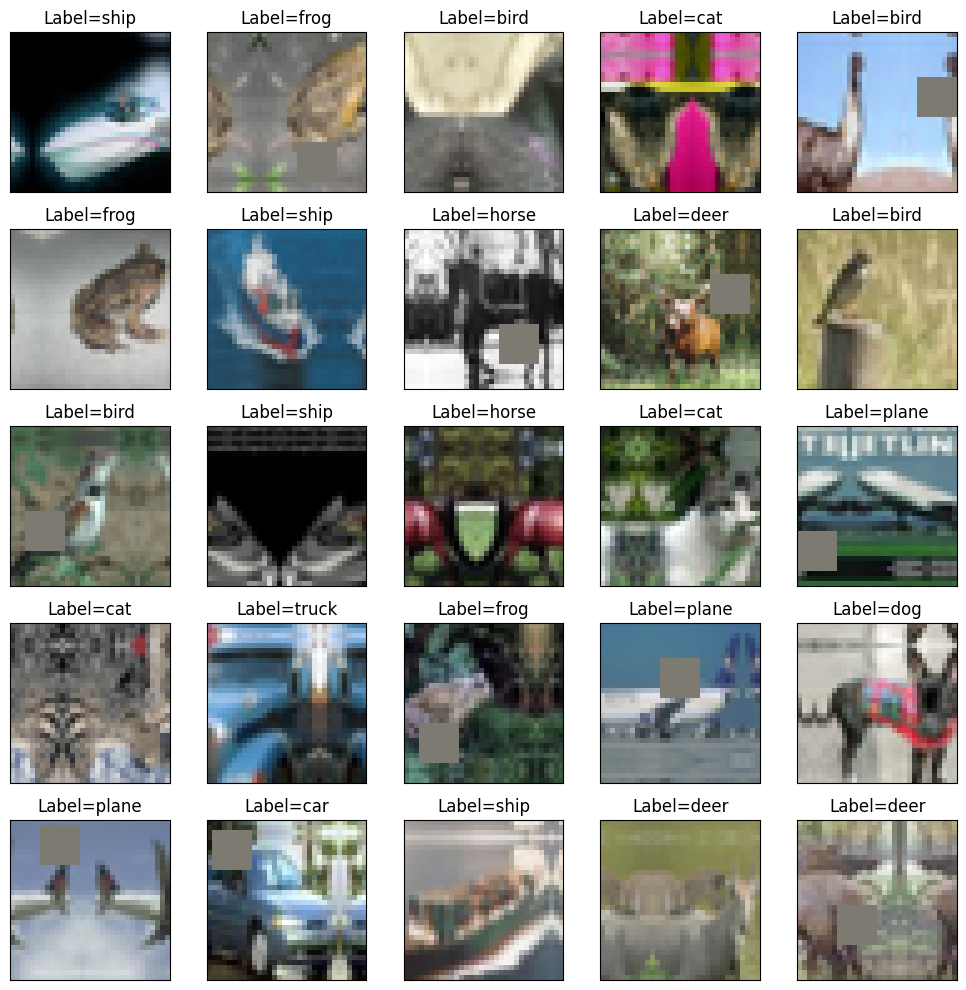

In [13]:
cifar10.sample_pictures(train_flag=True)

## Model

In [15]:
from models.resnet import *

# Loading Custom Model

# net = Net()
net = ResNet18()
# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


## Model Summary

In [16]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-03


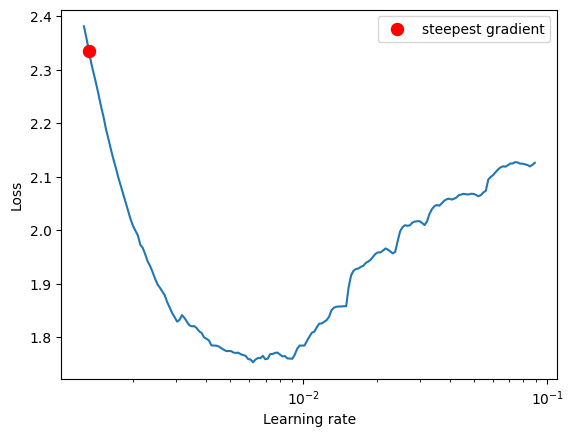

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.0013200884008314178)

In [17]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

net_exp = copy.deepcopy(net)
optimizer = torch.optim.Adam(net_exp.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=0.1, num_iter=200)
lr_finder.plot()

## Define a Loss function and optimizer

In [18]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01) #, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1.32E-03,
                                                steps_per_epoch=len(trainloader),
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False,
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

## Training & Testing

In [19]:
# Load train and test model
from main import train, test

train = train()
test = test()

EPOCHS= 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.run(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

Epoch: 0,Loss=1.46 Batch_id=97 Accuracy=42.13: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set: Average loss: 0.0033, Accuracy: 4483/10000 (44.83%)



Epoch: 1,Loss=1.14 Batch_id=97 Accuracy=55.32: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0032, Accuracy: 5024/10000 (50.24%)



Epoch: 2,Loss=0.95 Batch_id=97 Accuracy=62.83: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0024, Accuracy: 6030/10000 (60.30%)



Epoch: 3,Loss=0.78 Batch_id=97 Accuracy=67.80: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0028, Accuracy: 5826/10000 (58.26%)



Epoch: 4,Loss=0.93 Batch_id=97 Accuracy=71.39: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0022, Accuracy: 6697/10000 (66.97%)



Epoch: 5,Loss=0.68 Batch_id=97 Accuracy=75.43: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0012, Accuracy: 7923/10000 (79.23%)



Epoch: 6,Loss=0.60 Batch_id=97 Accuracy=77.91: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0013, Accuracy: 7687/10000 (76.87%)



Epoch: 7,Loss=0.48 Batch_id=97 Accuracy=80.27: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]



Test set: Average loss: 0.0015, Accuracy: 7570/10000 (75.70%)



Epoch: 8,Loss=0.55 Batch_id=97 Accuracy=81.99: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0012, Accuracy: 8001/10000 (80.01%)



Epoch: 9,Loss=0.41 Batch_id=97 Accuracy=83.33: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0009, Accuracy: 8392/10000 (83.92%)



Epoch: 10,Loss=0.42 Batch_id=97 Accuracy=84.36: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]



Test set: Average loss: 0.0009, Accuracy: 8470/10000 (84.70%)



Epoch: 11,Loss=0.42 Batch_id=97 Accuracy=85.68: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0010, Accuracy: 8404/10000 (84.04%)



Epoch: 12,Loss=0.38 Batch_id=97 Accuracy=86.35: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]



Test set: Average loss: 0.0013, Accuracy: 8045/10000 (80.45%)



Epoch: 13,Loss=0.38 Batch_id=97 Accuracy=87.25: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]



Test set: Average loss: 0.0009, Accuracy: 8627/10000 (86.27%)



Epoch: 14,Loss=0.31 Batch_id=97 Accuracy=88.32: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0009, Accuracy: 8665/10000 (86.65%)



Epoch: 15,Loss=0.32 Batch_id=97 Accuracy=88.99: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0010, Accuracy: 8482/10000 (84.82%)



Epoch: 16,Loss=0.30 Batch_id=97 Accuracy=89.48: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]



Test set: Average loss: 0.0007, Accuracy: 8849/10000 (88.49%)



Epoch: 17,Loss=0.26 Batch_id=97 Accuracy=90.22: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]



Test set: Average loss: 0.0007, Accuracy: 8888/10000 (88.88%)



Epoch: 18,Loss=0.20 Batch_id=97 Accuracy=91.22: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0006, Accuracy: 9036/10000 (90.36%)



Epoch: 19,Loss=0.15 Batch_id=97 Accuracy=91.84: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]



Test set: Average loss: 0.0006, Accuracy: 9034/10000 (90.34%)

Finished Training


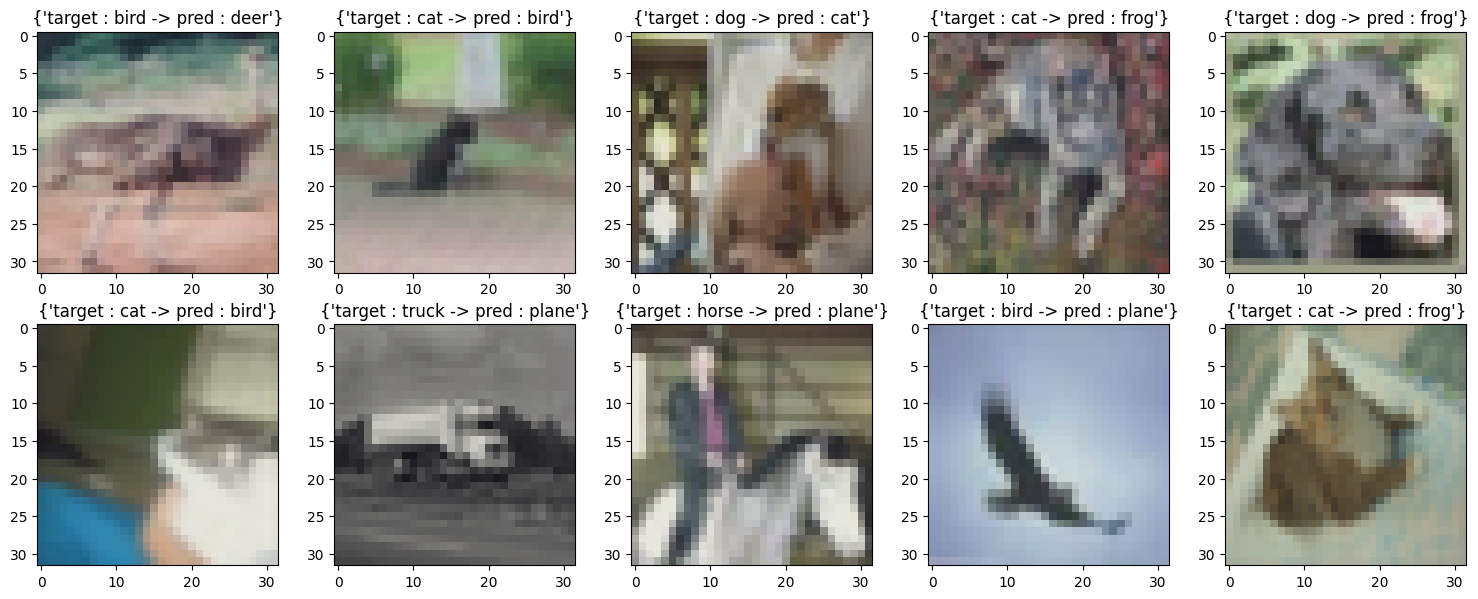

In [21]:
#collect misclassified images
import random

test.plt_misclassified_images()


In [33]:
net.layer3[-1]

BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

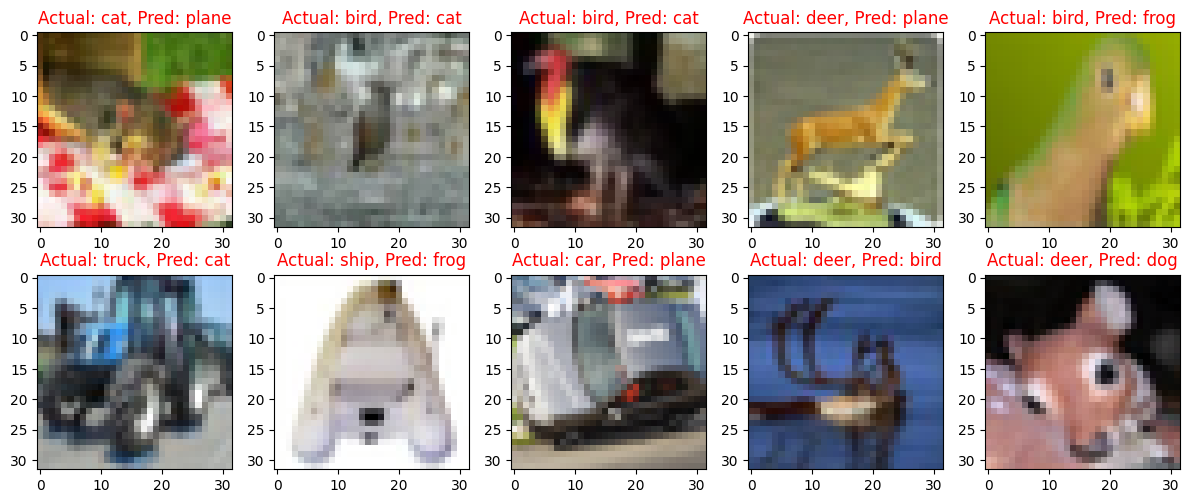

In [45]:
from utils import plot_grad_cam_images

plot_grad_cam_images(net, misclassified_samples, ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck'), apply_grad = False)


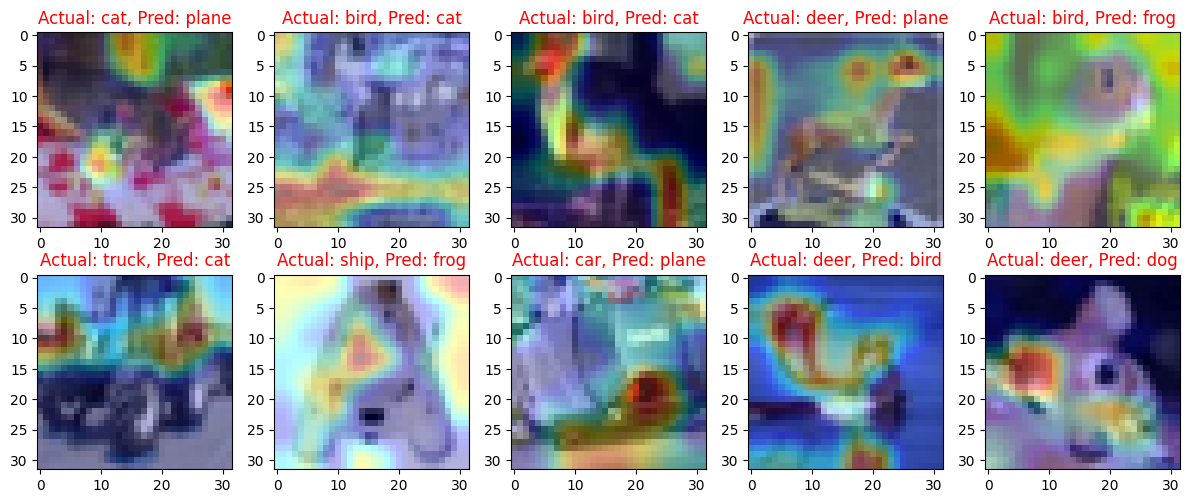

In [46]:
plot_grad_cam_images(net, misclassified_samples, ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck'), apply_grad = True)

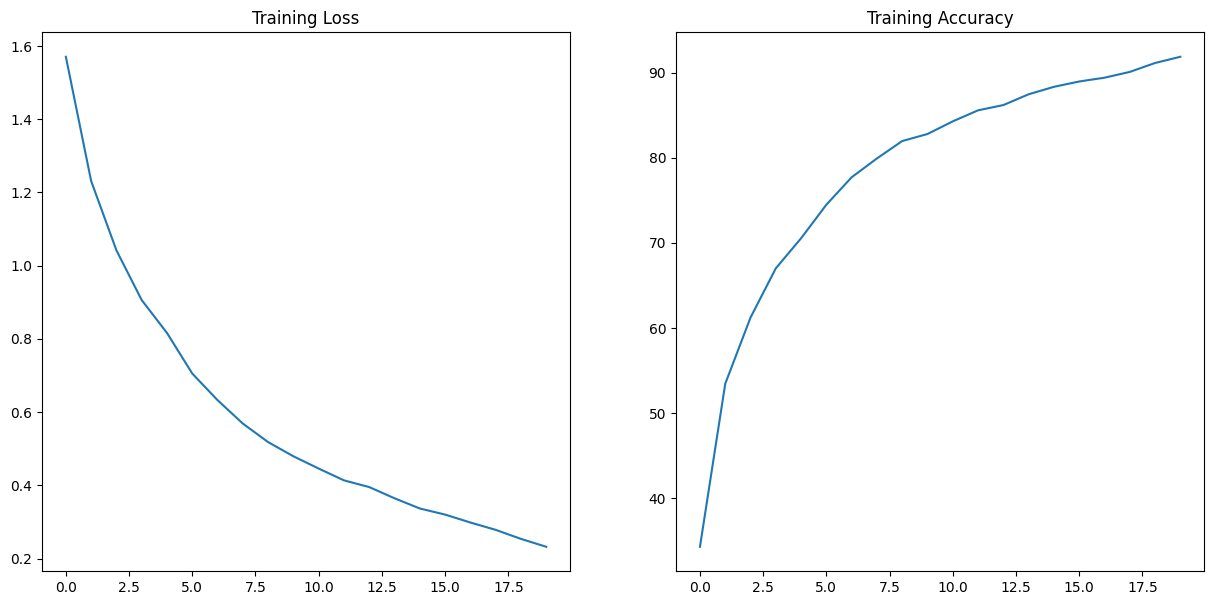

In [38]:
train.plot_trining_process()

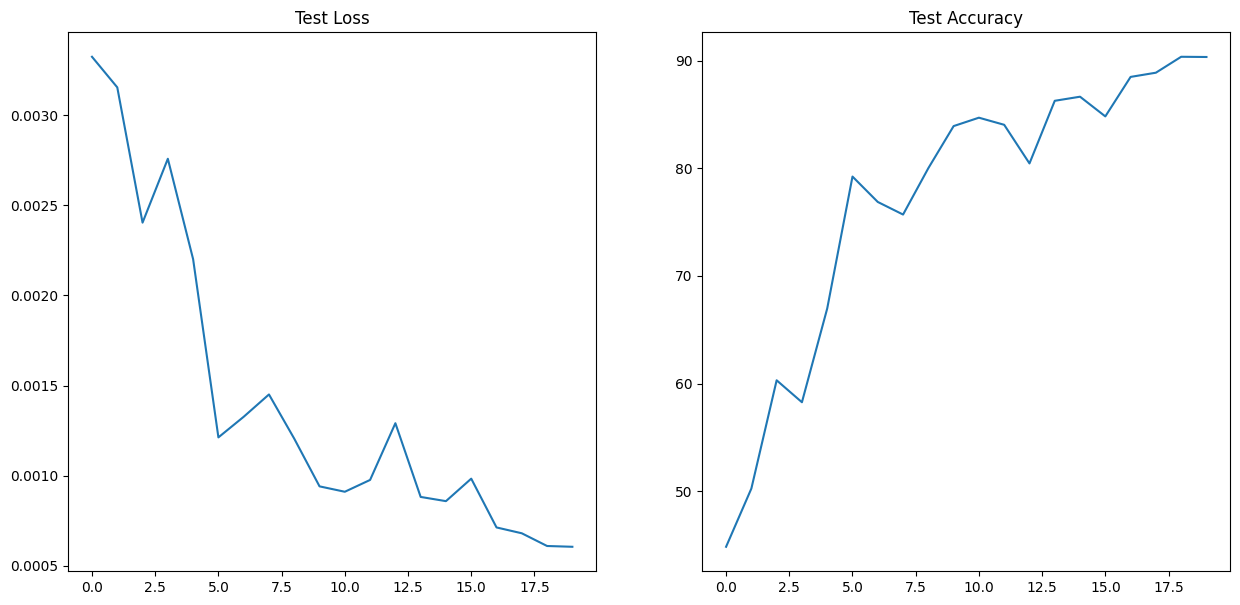

In [39]:
test.plot_test_process()